<a href="https://colab.research.google.com/github/FSNLSTR/PythonProjects/blob/main/MLSP_Project05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import scipy
import numpy as np
import pandas as pd
import librosa as lb
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Audio

P1

In [ ]:
trs, sr = lb.load('trs.wav', sr=None)

def dft_matrix(m_size):
  dft_matrix = np.array([[np.exp(-1j * (2 * np.pi * f * n / m_size)) for f in range(0, m_size)] for n in range(0, m_size)])
  return dft_matrix

def h_window(data, size):
  hann = np.hanning(size)
  new_data = []
  counter = 0

  while (counter + size) <= data.shape[0]:
    window = np.multiply(data[counter:counter+size], hann)
    new_data.append(window)
    counter += int(size/2)

  new_matrix = np.array(new_data).T
  return new_matrix

dft = dft_matrix(1024)
trs_h = h_window(trs, 1024)
trs_s = np.abs(np.dot(dft, trs_h)[:513,:]) #Only using the first 513 rows since the second half is just a mirror of the first
trs_s.shape

(513, 786)

In [ ]:
# Reading in trn
trn, sr = lb.load('trn.wav', sr = None)
trn_h = h_window(trn, 1024)
trn_s = np.abs(np.dot(dft, trn_h)[:513,:])
trn_s.shape

(513, 786)

In [ ]:
def plsi(X, max_iter=3000, tol=1e-6):
  num_topics = 30
  B = np.random.rand(X.shape[0], num_topics)
  theta = np.random.rand(num_topics, X.shape[1])
  I_V = np.ones((X.shape[0], X.shape[0]))
  I_K = np.ones((X.shape[1], X.shape[1]))

  for i in range(max_iter):
    # E-step and M-step combined for updating B
    B = B * ((X/(B @ theta)) @ theta.T)
    B = B / (I_V @ B)


    # E-step and M-step combined for updating theta
    theta = theta * (B.T @ (X / np.dot(B, theta)))
    theta = theta / (theta @ I_K)

  return B, theta

B_s, theta_s = plsi(trs_s)
B_s.shape

(513, 30)

In [ ]:
B_n, theta_n = plsi(trn_s)
B_n.shape

(513, 30)

In [ ]:
B = np.concatenate((B_s, B_n), axis = 1)
B.shape

(513, 60)

In [ ]:
def plsi_theta(X, B, max_iter=3000, tol=1e-6):
  #Doubled the number of topics to match the B's dimensions
  num_topics = 60
  theta = np.random.rand(num_topics, X.shape[1])
  I_K = np.ones((X.shape[1], X.shape[1]))

  for i in range(max_iter):
    theta = theta * (B.T @ (X / np.dot(B, theta)))
    theta = theta / (theta @ I_K)
  return theta

def idft_matrix(m_size):
  dft_matrix = np.array([[np.exp(1j * (2 * np.pi * f * n /m_size)) for f in range(0,m_size)] for n in range(0,m_size)])
  idft_matrix = dft_matrix/m_size
  return idft_matrix

In [ ]:
tes, sr = lb.load('tes.wav', sr=None)
tes_h = h_window(tes, 1024)
tes_s = np.dot(dft, tes_h)[:513,:] # X
abs_tes_s = np.abs(tes_s) # Y
print(tes_s.shape, abs_tes_s.shape)

(513, 98) (513, 98)


In [ ]:
theta = plsi_theta(abs_tes_s, B)
theta.shape

(60, 98)

In [ ]:
M_bar = np.dot(B_s, theta[0:30, :])/np.dot(B, theta)
S_hat = M_bar * tes_s
S_hat.shape

(513, 98)

In [ ]:
S = np.concatenate((S_hat, np.flip(np.conjugate(S_hat[1:512, :]), axis = 0)), axis=0)
S.shape

(1024, 98)

In [ ]:
inverse_dft = idft_matrix(1024)
S_r = (inverse_dft @ S).real
S_td = S_r[:(S_r.shape[0] - int(1024/2)),0]

for column in range(1,S_r.shape[1]):
  X_col = S_r[(S_r.shape[0] - int(1024/2)):,column-1] + S_r[0:int(1024/2), column]
  S_td = np.concatenate((S_td, X_col))

S_td = S_td.reshape(-1)
S_td.shape

(50176,)

In [ ]:
# Calculate Signal-to-Noise Ratio (SNR)
S_td = np.pad(S_td, (0, len(tes) - len(S_td)), 'constant')

SNR = 10 * np.log10(np.dot(tes.T, tes) / np.dot((tes - S_td).T, (tes - S_td)))
print("tes SNR:", SNR)

tes SNR: 11.736420495434318


In [ ]:
tex, sr = lb.load('tex.wav', sr=None)
tex_h = h_window(tex, 1024)
tex_s = np.dot(dft, tex_h)[:513,:] # X
abs_tex_s = np.abs(tex_s) # Y
print(tex_s.shape, abs_tex_s.shape)

(513, 98) (513, 98)


In [ ]:
theta = plsi_theta(abs_tex_s, B)
theta.shape

(60, 98)

In [ ]:
M_bar = np.dot(B_s, theta[0:30, :])/np.dot(B, theta)
S_hat = M_bar * tex_s
S_hat.shape

(513, 98)

In [ ]:
S = np.concatenate((S_hat, np.flip(np.conjugate(S_hat[1:512, :]), axis = 0)), axis=0)
S.shape

(1024, 98)

In [ ]:
inverse_dft = idft_matrix(1024)
S_r = (inverse_dft @ S).real
S_td = S_r[:(S_r.shape[0] - int(1024/2)),0]

for column in range(1,S_r.shape[1]):
  X_col = S_r[(S_r.shape[0] - int(1024/2)):,column-1] + S_r[0:int(1024/2), column]
  S_td = np.concatenate((S_td, X_col))

S_td = S_td.reshape(-1)
S_td.shape

(50176,)

In [ ]:
# Calculate Signal-to-Noise Ratio (SNR)
S_td = np.pad(S_td, (0, len(tex) - len(S_td)), 'constant')

SNR = 10 * np.log10(np.dot(tex.T, tex) / np.dot((tex - S_td).T, (tex - S_td)))
print("tex SNR:", SNR)

tex SNR: 5.285431316967073


P2

In [ ]:
# Load the faces data
faces_data = np.load('faces.npy')
faces_data.shape

(441, 8)

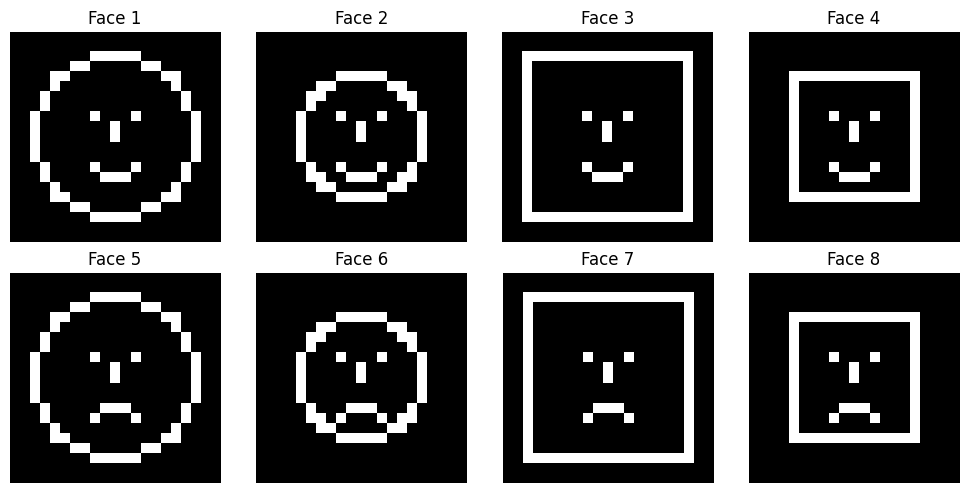

In [ ]:
# Plot the eight human faces
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    face = faces_data[:, i].reshape(21, 21)
    ax.imshow(face, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Face {i+1}')
plt.tight_layout()
plt.show()

((441, 6), (6, 8))


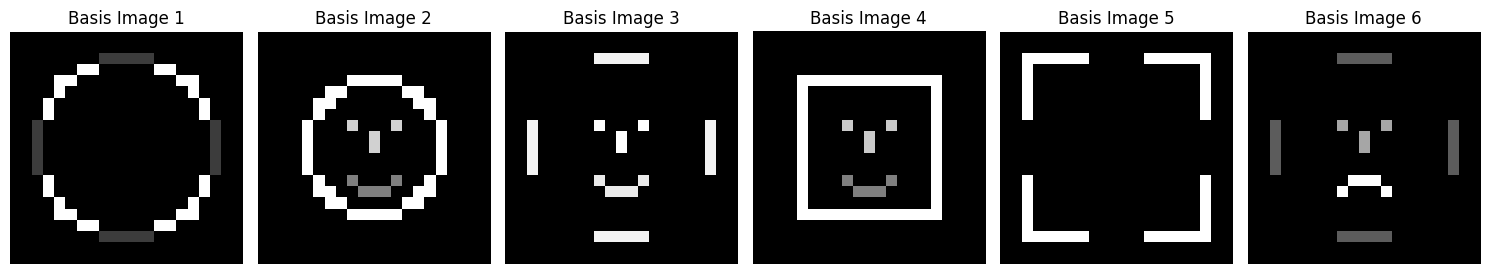

In [ ]:
def plsi_face(X, K, max_iter=10000, epsilon=1e-6):
    # Initialize B and Theta randomly
    num_faces = X.shape[1]
    num_features = X.shape[0]

    B = np.random.rand(num_features, K)
    theta = np.random.rand(K, num_faces)

    I_V = np.ones((X.shape[0], X.shape[0]))
    I_K = np.ones((X.shape[1], X.shape[1]))

    # EM algorithm
    for _ in range(max_iter):
        B = B * ((X/(epsilon + (B @ theta))) @ theta.T)
        B = B / (I_V @ B)

        theta = theta * (B.T @ (X / (epsilon + (B @ theta))))
        theta = theta / (theta @ I_K)

    return B, theta


# Define a function to train PLSI model and plot basis images
def train_and_plot_plsi(K):
    # Train PLSI model
    B, theta = plsi_face(faces_data, K)
    print((B.shape, theta.shape))

    # Plot basis images
    fig, axes = plt.subplots(1, K, figsize=(15, 5))
    for k, ax in enumerate(axes.flat):
        basis_image = B[:, k].reshape(21, 21)
        ax.imshow(basis_image, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Basis Image {k+1}')
    plt.tight_layout()
    plt.show()

    return B, theta

# Choose the optimal K (2 head sizes, 2 head shapes, 2 mouth positions)
optimal_K = 6

# Train PLSI model with optimal K and plot basis images
B, theta = train_and_plot_plsi(optimal_K)

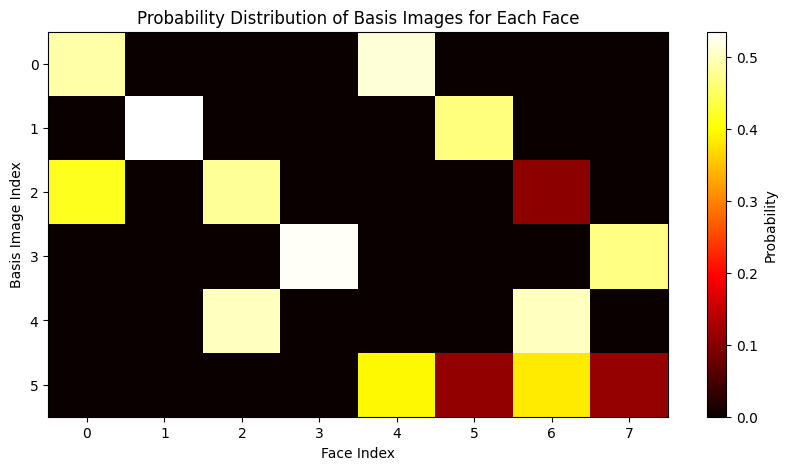

In [ ]:
# Plot Theta
plt.figure(figsize=(10, 5))
plt.imshow(theta, cmap='hot', aspect='auto')
plt.colorbar(label='Probability')
plt.xlabel('Face Index')
plt.ylabel('Basis Image Index')
plt.title('Probability Distribution of Basis Images for Each Face')
plt.show()


In [ ]:
# Reconstruct input images
X_reconstructed = B @ theta



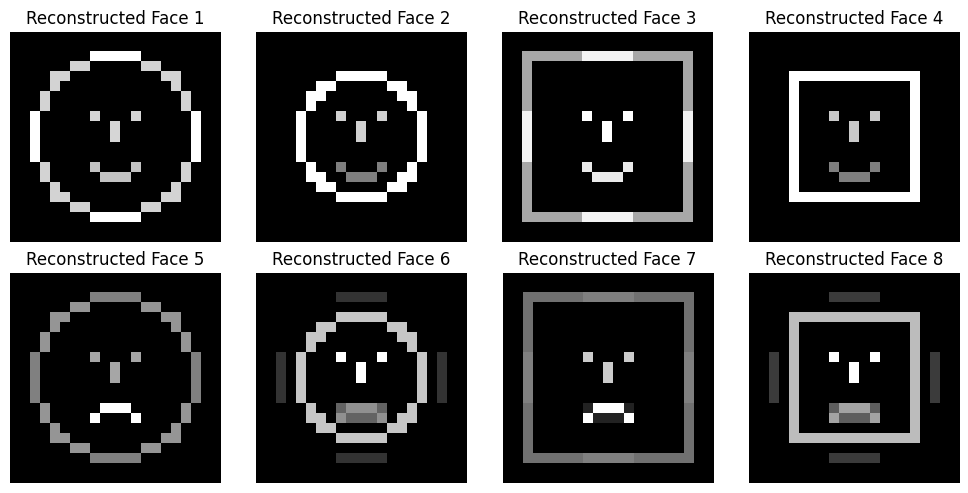

In [ ]:
# Plot reconstructed images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    reconstructed_image = X_reconstructed[:, i].reshape(21, 21)
    ax.imshow(reconstructed_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Reconstructed Face {i+1}')
plt.tight_layout()
plt.show()


P3

In [ ]:
x = scipy.io.loadmat('x_formerly_known_as_twitter.mat')
Xtr = x['Xtr']
Xte = x['Xte']
YtrMat = x['YtrMat']
YteMat = x['YteMat']

p_topics = np.random.randn(891, 50)
p_weights = np.random.randn(50, 773)

In [ ]:
for i in range(500):
  den = p_topics @ p_weights
  den[den == 0] = 0.0001

  p_topics *= (Xtr/den) @ p_weights.T
  p_topics /= np.ones([p_topics.shape[0], p_topics.shape[0]]) @ p_topics

  den = p_topics @ p_weights
  den[den == 0] = 0.0001

  p_weights *= p_topics.T @ (Xtr/den)
  p_weights /= np.ones([p_weights.shape[0], p_weights.shape[0]]) @ p_weights
p_weights.shape

(50, 773)

In [ ]:
p_weights2 = np.random.rand(50,193)

for i in range(500):
  den = p_topics @ p_weights2
  den[den == 0] = 0.0001

  p_weights2 *= p_topics.T @ (Xte/den)
  p_weights2 /= np.ones([p_weights2.shape[0], p_weights2.shape[0]]) @ p_weights2

p_weights2.shape

(50, 193)

In [ ]:
alpha = 0.005

W = np.random.uniform(0, 5, (3, p_weights.shape[0]))
b = np.random.uniform(0, 5, (3,1))
error_plot = []

for i in range(1000):
  Y_hat = np.exp(np.dot(W, p_weights) + b)
  Y_hat /= np.sum(Y_hat, axis=0).reshape(1,-1)

  error = -np.sum(YtrMat * np.log(Y_hat))

  difference = (Y_hat - YtrMat)

  delta_w =  difference @ p_weights.T
  delta_b = difference @ np.ones([YtrMat.shape[1],1])

  W -= (alpha * delta_w)
  b -= (alpha * delta_b)

  error_plot.append(error)

In [ ]:
Z = (W @ p_weights2) + b
Y_hat_test = np.exp(Z)

Y_hat_test /= np.sum(Y_hat_test, axis=0).reshape(1,-1)

train_accuracy = np.sum(np.argmax(Y_hat, axis=0) == np.argmax(YtrMat, axis=0)) / YtrMat.shape[1]
test_accuracy = np.sum(np.argmax(Y_hat_test, axis=0) == np.argmax(YteMat, axis=0)) / YteMat.shape[1]

print('Training acc: ' + str(np.round(train_accuracy, 4)))
print('Testing acc: ' + str(np.round(test_accuracy, 4)))

Training acc: 0.6197
Testing acc: 0.5699


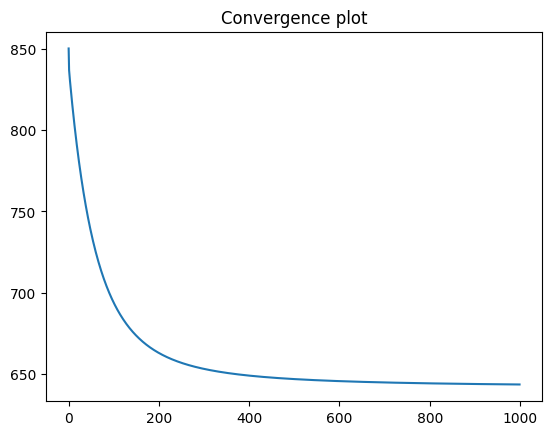

In [ ]:

plt.title('Convergence plot')
plt.plot(error_plot)
plt.show()

P4

In [ ]:
trX = scipy.io.loadmat('trX.mat')['trX']
trY = scipy.io.loadmat('trY.mat')['trY']
print(trX.shape, trY.shape)

(2, 160) (1, 160)


In [ ]:
def Ada_Boost(learnerCount, max_epochs, alpha, trX, trY):
    fx = 0
    l_weights = np.ones((1,trX.shape[1]))
    error_adaboost, l_weights_list, beta_list = list(), list(), list()

    for m in range(learnerCount):
        W, b = np.random.uniform(-2, 2, (1, 2)), np.random.uniform()
        epoch = 0
        while epoch <= max_epochs:

            Z = np.dot(W, trX) + b
            pred = np.tanh(Z)

            b_error = -l_weights * (trY - pred) * (1 - pred**2)
            delta_w = b_error @ trX.T
            delta_b = b_error @ np.ones_like(trY).T

            W -= (alpha * delta_w)
            b -= (alpha * delta_b)

            epoch += 1

        beta = 0.5 * np.log(np.sum(l_weights * (np.sign(pred) == trY)) / np.sum(l_weights * (np.sign(pred) != trY)))
        fx += beta * np.sign(pred)
        error = np.sum(np.sign(fx) != trY)
        l_weights *= np.exp(- beta * trY * np.sign(pred))

        error_adaboost.append(error)
        l_weights_list.append(l_weights)

    return fx, error_adaboost

fx, error_adaboost = Ada_Boost(1000, 500, 0.05, trX, trY)

print("Accuracy: " + str(np.sum(np.sign(fx) == trY) / trY.shape[1]))

Accuracy: 0.78125


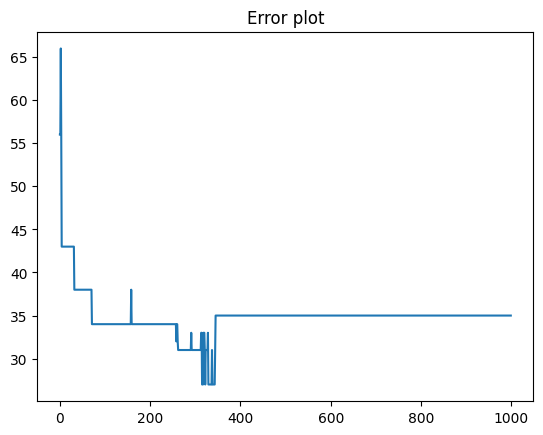

In [ ]:
plt.title('Error plot')
plt.plot(error_adaboost)
plt.show()

In [ ]:
!jupyter nbconvert --to html MLSP_Project05-3.ipynb

[NbConvertApp] Converting notebook MLSP_Project05-3.ipynb to html
[NbConvertApp] Writing 800211 bytes to MLSP_Project05-3.html
